In [1]:
from rtree import index
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def initiate(radius,C,L):
    coordinate = np.ones(2)*L/2.0
    nodelist = {(coordinate[0],coordinate[1]):{5:0.0,7:1}} #5：到心距 7：点数
    index2coor = {1:(coordinate[0],coordinate[1])}
    idx = index.Index()
    idx.insert(1,list(np.r_[coordinate,coordinate]))                     
    limitt = np.r_[coordinate - radius,coordinate + radius] 
    return nodelist,idx,limitt,index2coor
	
def choosenode(nodelist,limitt,C,index2coor):#?
    white = ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1])-len(nodelist) )*C
    exist = len(index2coor)+len(nodelist)*C
    rnd = random.random()*( exist + white )
    if rnd>exist:
        while 1:
            ii = int( random.random()*(limitt[2]-limitt[0])   + limitt[0] )
            jj = int( random.random()*(limitt[3]-limitt[1])   + limitt[1] )
            if (ii,jj) not in nodelist:
                return (ii,jj),0
    else:
        pos = random.randint(1,len(index2coor))#右闭
        return index2coor[pos],1
		
def onestep(nodelist,index2coor,idx,radius,C,h,limitt,L):
    two,flag = choosenode(nodelist,limitt,C,index2coor)  
    i = two[0]
    j = two[1]
    if flag == 0:
        intersection = list(idx.intersection([i-radius,j-radius, i+radius,j+radius])) 
        if len(intersection) > 0:
            for key in intersection:
                if np.linalg.norm(np.array([index2coor[key]]) - np.array([i,j])) <= radius:  
                    state = 1
                else:
                    state = 0
            if state == 1:
                nodelist,index2coor,idx,limitt = insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L)
        return nodelist,index2coor,idx,limitt      

    elif flag==1: 
        if nodelist[(i,j)][7]+1 <= h:#不溢
            nodelist[(i,j)][7] += 1
            index2coor[len(index2coor)+1]=(i,j)
        else:
            while ((i,j) in nodelist.keys()) and (nodelist[(i,j)][7]+1 > h) :
                (i,j) = sandpile(i,j,h,nodelist)
            if (i,j) in nodelist.keys():#溢出到有点的格子
                nodelist[(i,j)][7] += 1
                index2coor[len(index2coor)+1]=(i,j)
            else:#溢出到空格子
                nodelist,index2coor,idx,limitt  = insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L)
        return nodelist,index2coor,idx,limitt
		
def insert_newpoint(i,j,nodelist,index2coor,idx,limitt,L):
	nodelist[(i,j)] = {5:np.linalg.norm(np.array([i,j])-L/2),7:1}
	index2coor[len(index2coor)+1]=(i,j)
	newpoint = [i,j]
	idx.insert( len(index2coor), np.r_[newpoint, newpoint] )  ###idx
	for x in range(2):
		limitt[x]   = round(min(limitt[x],newpoint[x]-radius))
		limitt[x+2] = round(max(limitt[x+2],newpoint[x]+radius))
	return nodelist,index2coor,idx,limitt

def sandpile(i,j,h,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    deltas = []
    #邻接阵arov
    arov={}
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        deltas.append(delta)
    B = np.cumsum(deltas)
    if B[-1]!= 0:
        rnd = random.random()*B[-1]
        ind = np.nonzero(B<rnd)
        if len(ind[0])==0:
            pos = 1
        else:
            pos = ind[0][-1]+2
    else:#九格同
        pos = 5 
        while pos == 5:
            pos = random.randint(1,9)
		#pos = 1 #左下
		#pos = 9 #右上
    #得到位置
    return arounddic[pos]        

def caculate(nodelist,radius):
    w = []
    delta  = radius
	#delta = radius/2#qqq
    for key in nodelist:
        w.append([nodelist[key][5],nodelist[key][7]])
    w.sort()
    w = np.array(w)
    R = np.arange(0,np.max(w[:,0]),delta)
    RL = np.zeros((len(R),2)) 
    RL[:,0] = R
    for i in range(len(RL)):
        RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
    Rrho = np.zeros((len(R),2))
    Rrho[:,0] = R + delta/2
    for i in range(len(Rrho)-1):
        Rrho[i,1] = (RL[i+1,1] - RL[i,1])/(math.pi*(delta**2+2*delta*RL[i,0]))
    a = Rrho
    xx = np.nonzero(a[:,1]==0) 
    if len(xx[0])==0:
        x = 0 
    else:
        x = xx[0][0]
    Rrhox = Rrho[:x,:x]
    return Rrhox

def save(Rx,C,radius,maxnode,h=3,i=1):#i 预留次数参数
    se = {}
    for i in range(1,len(Rx)+1):
        se[i] = pd.Series(Rx[i])
    df = pd.concat([se[i] for i in range(1,len(Rx)+1) ],axis = 1)
    name = "C"+str(C)+"--r"+str(radius)+"--maxnode"+str(maxnode)+"--h"+str(h)+"--i"+str(i)
    df.to_csv(name+".csv")
    print("Winner winner chicken dinner")

def side_view(nodelist):
    h = []
    for k in nodelist:
        h.append(nodelist[k][7])
    a = Counter(h)
    print(a)
	
def spatial_range(nodelist):
    x = []
    y = []
    for k in nodelist.keys():
        x.append(k[0])
        y.append(k[1])
    return max(x),min(x),max(y),min(y)

def paint(nodelist):
	x = nodelist
	a = []
	m = []
	n = []
	c = []
	xmax,xmin,ymax,ymin = spatial_range(x)
	for k,v in x.items():
		a.append(k)
		c.append(1/(v[7]))
	for i in a:
		m.append(i[0])
		n.append(i[1])
	plt.figure(figsize=(10,10),dpi=100)
	plt.scatter(m,n,s = 0.1,c = c)
	plt.xlim((xmin,xmax))
	plt.ylim((ymin,ymax))
	plt.show()


In [ ]:
radius = 10
C = 0.04
maxnode = 10000
h = 
L = 10**5
nodelist,idx,limitt,index2coor= initiate(radius,C,L)
tstep = 1
n = 1
i = 1#实验次数，可加循环
Rx = {}

In [33]:
for h in range(2,10):
    for i in range(0,21):
        radius = 10
        C = 0.04
        maxnode = 10000
        L = 10**5
        nodelist,idx,limitt,index2coor= initiate(radius,C,L)
        tstep = 1
        n = 1
        Rx = {}
        while len(index2coor) < maxnode:
            k1 = len(index2coor)
            nodelist,index2coor,idx,limitt = onestep(nodelist,index2coor,idx,radius,C,h,limitt,L)
            k2 = len(index2coor)
            if (k1 != k2) and k2%10000 == 0:          
                Rrhox = caculate(nodelist,radius)
                print(h,i,Rrhox[-1,0]) 
                n += 1
        #break
            tstep += 1

2 0 165.0
2 1 165.0
2 2 175.0
2 3 155.0
2 4 155.0
2 5 145.0
2 6 155.0
2 7 145.0
2 8 145.0
2 9 145.0
2 10 165.0
2 11 145.0
2 12 165.0
2 13 155.0
2 14 165.0
2 15 185.0
2 16 155.0
2 17 135.0
2 18 135.0
2 19 135.0
2 20 185.0
3 0 175.0
3 1 155.0
3 2 135.0
3 3 155.0
3 4 135.0
3 5 155.0
3 6 135.0
3 7 155.0
3 8 145.0
3 9 135.0
3 10 155.0
3 11 165.0
3 12 175.0
3 13 185.0
3 14 175.0
3 15 165.0
3 16 165.0
3 17 165.0
3 18 185.0
3 19 145.0
3 20 145.0
4 0 185.0
4 1 135.0
4 2 175.0
4 3 165.0
4 4 205.0
4 5 165.0
4 6 145.0
4 7 155.0
4 8 145.0
4 9 155.0
4 10 165.0
4 11 165.0
4 12 155.0
4 13 175.0
4 14 175.0
4 15 185.0
4 16 135.0
4 17 155.0
4 18 145.0
4 19 175.0
4 20 165.0
5 0 175.0
5 1 195.0
5 2 145.0
5 3 135.0
5 4 145.0
5 5 175.0
5 6 165.0
5 7 175.0
5 8 125.0
5 9 155.0
5 10 165.0
5 11 155.0
5 12 165.0
5 13 155.0
5 14 165.0
5 15 155.0
5 16 165.0
5 17 175.0
5 18 145.0
5 19 175.0
5 20 155.0
6 0 155.0
6 1 175.0
6 2 155.0
6 3 145.0
6 4 135.0
6 5 145.0
6 6 155.0
6 7 155.0
6 8 155.0
6 9 155.0
6 10 135.0
6 11 

In [30]:
radius = 10
C = 0.04
maxnode = 10000
h = 
L = 10**5
nodelist,idx,limitt,index2coor= initiate(radius,C,L)
tstep = 1
n = 1
i = 1#实验次数，可加循环
Rx = {}

PPP 6662 5000 1610
Counter({1: 714, 2: 271, 3: 166, 10: 150, 4: 109, 5: 64, 6: 47, 7: 31, 8: 31, 9: 27})
(50088, 49860, 50122, 49920)


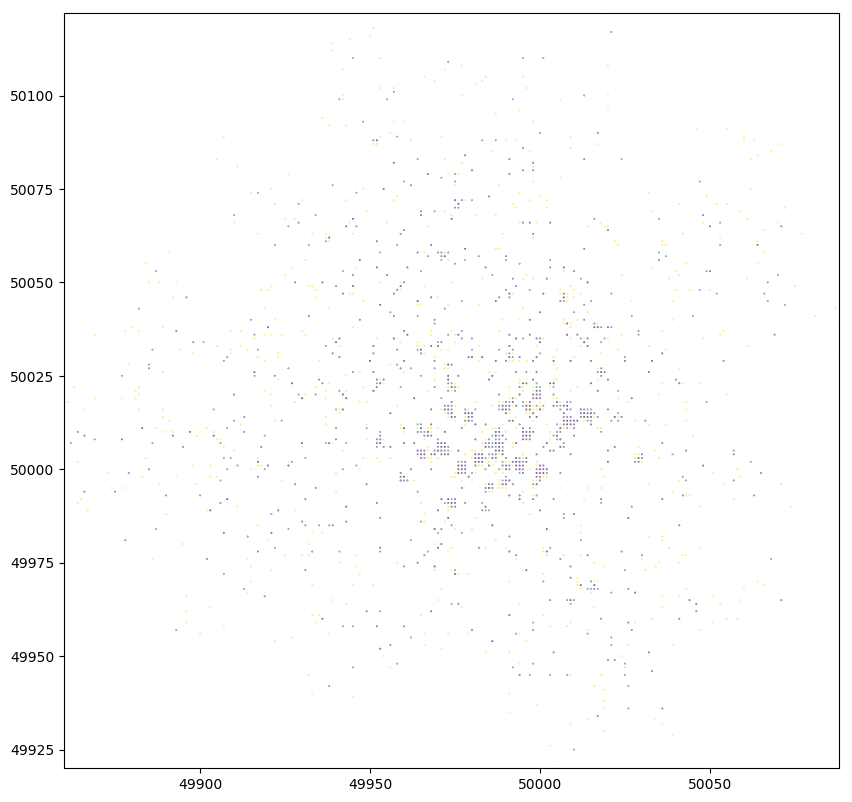

PPP 12560 10000 2826
Counter({1: 1072, 2: 499, 10: 352, 3: 290, 4: 181, 5: 138, 6: 103, 7: 73, 8: 65, 9: 53})
(50120, 49840, 50136, 49907)


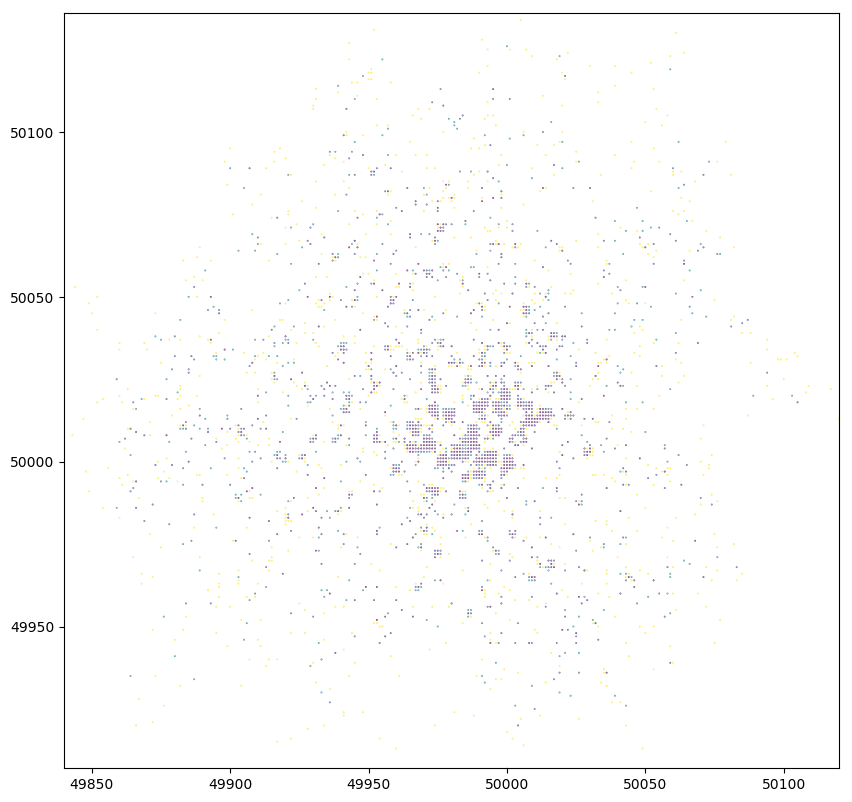

In [31]:
while len(index2coor) < maxnode:
    k1 = len(index2coor)
    nodelist,index2coor,idx,limitt = onestep(nodelist,index2coor,idx,radius,C,h,limitt,L)
    k2 = len(index2coor)
    if (k1 != k2) and k2%5000 == 0:
        print ('PPP',tstep, len(index2coor), len(nodelist))
        side_view(nodelist)
        print (spatial_range(nodelist))
        paint(nodelist)
        Rrhox = caculate(nodelist,radius)
        Rx[n] = Rrhox[:,1]
        n += 1
        #break
    tstep += 1

In [32]:
w = []
delta  = 10
	#delta = radius/2#qqq
for key in nodelist:
    w.append([nodelist[key][5],nodelist[key][7]])
w.sort()
w = np.array(w)
R = np.arange(0,np.max(w[:,0]),delta)
RL = np.zeros((len(R),2)) 
RL[:,0] = R
for i in range(len(RL)):
    RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
Rrho = np.zeros((len(R),2))
Rrho[:,0] = R + delta/2
for i in range(len(Rrho)-1):
    Rrho[i,1] = (RL[i+1,1] - RL[i,1])/(math.pi*(delta**2+2*delta*RL[i,0]))
a = Rrho
xx = np.nonzero(a[:,1]==0) 
if len(xx[0])==0:
    x = 0 
else:
    x = xx[0][0]
Rrhox = Rrho[:x,:x]
Rrhox

array([[  5.00000000e+00,   2.10721145e+00],
       [  1.50000000e+01,   1.74752128e+00],
       [  2.50000000e+01,   9.44107122e-01],
       [  3.50000000e+01,   6.47078526e-01],
       [  4.50000000e+01,   3.47665131e-01],
       [  5.50000000e+01,   1.98509620e-01],
       [  6.50000000e+01,   1.95393299e-01],
       [  7.50000000e+01,   1.18835691e-01],
       [  8.50000000e+01,   1.12906389e-01],
       [  9.50000000e+01,   6.56723555e-02],
       [  1.05000000e+02,   3.56203920e-02],
       [  1.15000000e+02,   3.37685271e-02],
       [  1.25000000e+02,   1.88439453e-02],
       [  1.35000000e+02,   1.19071476e-02],
       [  1.45000000e+02,   2.19524059e-03],
       [  1.55000000e+02,   1.33484791e-03]])